In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [2]:

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
     

2.4.0
cuda


## Transform data

In [3]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

# Transform image
data_transform = transforms.Compose([
    transforms.Resize(size = (256, 256)),         
    # transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
])

0.19.0


## Load data

In [4]:
# Setup train and test paths
train_dir = 'D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\train'
test_dir = 'D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\test'
val_dir = 'D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\val'
train_dir, test_dir, val_dir

('D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\train',
 'D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\test',
 'D:\\Hoc\\IEC_FRESHER\\BRT350 - Copy\\brain_tumor\\new_datasets\\val')

In [5]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)  

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)
val_data = datasets.ImageFolder(root = val_dir,
                                transform = data_transform)
train_data, test_data, val_data

(Dataset ImageFolder
     Number of datapoints: 1800
     Root location: D:\Hoc\IEC_FRESHER\BRT350 - Copy\brain_tumor\new_datasets\train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: D:\Hoc\IEC_FRESHER\BRT350 - Copy\brain_tumor\new_datasets\test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: D:\Hoc\IEC_FRESHER\BRT350 - Copy\brain_tumor\new_datasets\val
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [6]:
# Get class names as lists
class_names = train_data.classes
class_names

['no', 'yes']

In [7]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'no': 0, 'yes': 1}

In [8]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.float32,
 0,
 int,
 'no')

In [9]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256, 3]))

Text(0.5, 1.0, 'no')

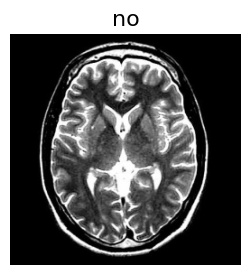

In [10]:
import matplotlib.pyplot as plt
# Plot the image
plt.figure(figsize = (3, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16)

In [11]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

val_dataloader = DataLoader(dataset = val_data,
                            batch_size = BATCH_SIZE,
                            num_workers = 1,
                            shuffle = False)

len(train_dataloader), len(test_dataloader), len(val_dataloader)

(57, 19, 19)

In [12]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

## Build model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 30 * 30, 256)  # Calculate size after pooling
        self.fc2 = nn.Linear(256, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.4)
        
        # L2 Regularization - use as weight decay in optimizer
    
    def forward(self, x):
        # Convolution 1 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolution 2 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Convolution 3 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected 1 -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Fully Connected 2 -> Sigmoid
        x = torch.sigmoid(self.fc2(x))
        
        return x


In [14]:
from torchinfo import summary


In [15]:
model = CNNModel(256).to(device)   # (input_shape, hidden_units, output_shape)
summary(model, input_size = [1, 3, 256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 2]                    --
├─Conv2d: 1-1                            [1, 32, 254, 254]         896
├─MaxPool2d: 1-2                         [1, 32, 127, 127]         --
├─Conv2d: 1-3                            [1, 32, 125, 125]         9,248
├─MaxPool2d: 1-4                         [1, 32, 62, 62]           --
├─Conv2d: 1-5                            [1, 64, 60, 60]           18,496
├─MaxPool2d: 1-6                         [1, 64, 30, 30]           --
├─Linear: 1-7                            [1, 256]                  14,745,856
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 2]                    514
Total params: 14,775,010
Trainable params: 14,775,010
Non-trainable params: 0
Total mult-adds (M): 283.64
Input size (MB): 0.79
Forward/backward pass size (MB): 22.36
Params size (MB): 59.10
Estimated Total S

## Train model

In [16]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

e:\Anaconda\envs\brain_tumor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [19]:
# Set random seed
# torch.manual_seed(42)
EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  3%|▎         | 1/30 [00:24<11:37, 24.04s/it]

Epoch: 0 | Train loss: 0.6098 - Train acc: 66.12% -  Test loss: 0.5328 - Test acc: 78.73%


  7%|▋         | 2/30 [00:48<11:15, 24.13s/it]

Epoch: 1 | Train loss: 0.5212 - Train acc: 78.40% -  Test loss: 0.4719 - Test acc: 82.68%


 10%|█         | 3/30 [01:12<10:51, 24.12s/it]

Epoch: 2 | Train loss: 0.4559 - Train acc: 85.14% -  Test loss: 0.4319 - Test acc: 87.83%


 13%|█▎        | 4/30 [01:36<10:28, 24.16s/it]

Epoch: 3 | Train loss: 0.4289 - Train acc: 87.88% -  Test loss: 0.4129 - Test acc: 89.69%


 17%|█▋        | 5/30 [02:01<10:07, 24.28s/it]

Epoch: 4 | Train loss: 0.3871 - Train acc: 92.65% -  Test loss: 0.3775 - Test acc: 93.75%


 20%|██        | 6/30 [02:25<09:44, 24.34s/it]

Epoch: 5 | Train loss: 0.3689 - Train acc: 94.79% -  Test loss: 0.3787 - Test acc: 93.75%


 23%|██▎       | 7/30 [02:49<09:19, 24.35s/it]

Epoch: 6 | Train loss: 0.3552 - Train acc: 95.89% -  Test loss: 0.3696 - Test acc: 94.24%


 27%|██▋       | 8/30 [03:14<08:58, 24.50s/it]

Epoch: 7 | Train loss: 0.3435 - Train acc: 97.42% -  Test loss: 0.3614 - Test acc: 95.07%


 30%|███       | 9/30 [03:39<08:34, 24.52s/it]

Epoch: 8 | Train loss: 0.3390 - Train acc: 97.48% -  Test loss: 0.3594 - Test acc: 95.39%


 33%|███▎      | 10/30 [04:03<08:11, 24.56s/it]

Epoch: 9 | Train loss: 0.3368 - Train acc: 97.81% -  Test loss: 0.3589 - Test acc: 95.07%


 37%|███▋      | 11/30 [04:28<07:45, 24.52s/it]

Epoch: 10 | Train loss: 0.3335 - Train acc: 98.03% -  Test loss: 0.3584 - Test acc: 95.23%


 40%|████      | 12/30 [04:52<07:21, 24.50s/it]

Epoch: 11 | Train loss: 0.3315 - Train acc: 98.36% -  Test loss: 0.3533 - Test acc: 95.72%


 43%|████▎     | 13/30 [05:17<06:58, 24.60s/it]

Epoch: 12 | Train loss: 0.3239 - Train acc: 99.07% -  Test loss: 0.3534 - Test acc: 95.56%


 47%|████▋     | 14/30 [05:42<06:32, 24.55s/it]

Epoch: 13 | Train loss: 0.3220 - Train acc: 99.18% -  Test loss: 0.3490 - Test acc: 96.71%


 50%|█████     | 15/30 [06:06<06:06, 24.44s/it]

Epoch: 14 | Train loss: 0.3227 - Train acc: 99.12% -  Test loss: 0.3489 - Test acc: 96.22%


 53%|█████▎    | 16/30 [06:30<05:43, 24.53s/it]

Epoch: 15 | Train loss: 0.3229 - Train acc: 99.29% -  Test loss: 0.3443 - Test acc: 97.20%


 57%|█████▋    | 17/30 [06:55<05:18, 24.51s/it]

Epoch: 16 | Train loss: 0.3204 - Train acc: 99.34% -  Test loss: 0.3467 - Test acc: 96.71%


 60%|██████    | 18/30 [07:20<04:54, 24.54s/it]

Epoch: 17 | Train loss: 0.3238 - Train acc: 99.01% -  Test loss: 0.3463 - Test acc: 96.71%


 63%|██████▎   | 19/30 [07:44<04:30, 24.60s/it]

Epoch: 18 | Train loss: 0.3317 - Train acc: 98.19% -  Test loss: 0.3497 - Test acc: 95.89%


 67%|██████▋   | 20/30 [08:09<04:05, 24.53s/it]

Epoch: 19 | Train loss: 0.3250 - Train acc: 98.90% -  Test loss: 0.3487 - Test acc: 96.38%


 70%|███████   | 21/30 [08:33<03:40, 24.54s/it]

Epoch: 20 | Train loss: 0.3189 - Train acc: 99.51% -  Test loss: 0.3412 - Test acc: 97.04%


 73%|███████▎  | 22/30 [08:58<03:16, 24.62s/it]

Epoch: 21 | Train loss: 0.3180 - Train acc: 99.51% -  Test loss: 0.3392 - Test acc: 97.53%


 77%|███████▋  | 23/30 [09:23<02:52, 24.64s/it]

Epoch: 22 | Train loss: 0.3178 - Train acc: 99.56% -  Test loss: 0.3363 - Test acc: 97.70%


 80%|████████  | 24/30 [09:47<02:27, 24.62s/it]

Epoch: 23 | Train loss: 0.3178 - Train acc: 99.56% -  Test loss: 0.3366 - Test acc: 97.53%


 83%|████████▎ | 25/30 [10:12<02:02, 24.58s/it]

Epoch: 24 | Train loss: 0.3182 - Train acc: 99.51% -  Test loss: 0.3444 - Test acc: 96.88%


 87%|████████▋ | 26/30 [10:36<01:38, 24.56s/it]

Epoch: 25 | Train loss: 0.3189 - Train acc: 99.45% -  Test loss: 0.3434 - Test acc: 96.71%


 90%|█████████ | 27/30 [11:01<01:13, 24.53s/it]

Epoch: 26 | Train loss: 0.3187 - Train acc: 99.45% -  Test loss: 0.3565 - Test acc: 95.50%


 93%|█████████▎| 28/30 [11:25<00:49, 24.54s/it]

Epoch: 27 | Train loss: 0.3168 - Train acc: 99.73% -  Test loss: 0.3412 - Test acc: 97.20%


 97%|█████████▋| 29/30 [11:50<00:24, 24.64s/it]

Epoch: 28 | Train loss: 0.3216 - Train acc: 99.23% -  Test loss: 0.3397 - Test acc: 97.20%


100%|██████████| 30/30 [12:15<00:00, 24.50s/it]

Epoch: 29 | Train loss: 0.3283 - Train acc: 98.41% -  Test loss: 0.3499 - Test acc: 96.05%
Total Train Time: 735.151 seconds


## Plot curve

In [20]:
# Get the model key results
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [21]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary """

    # Get results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

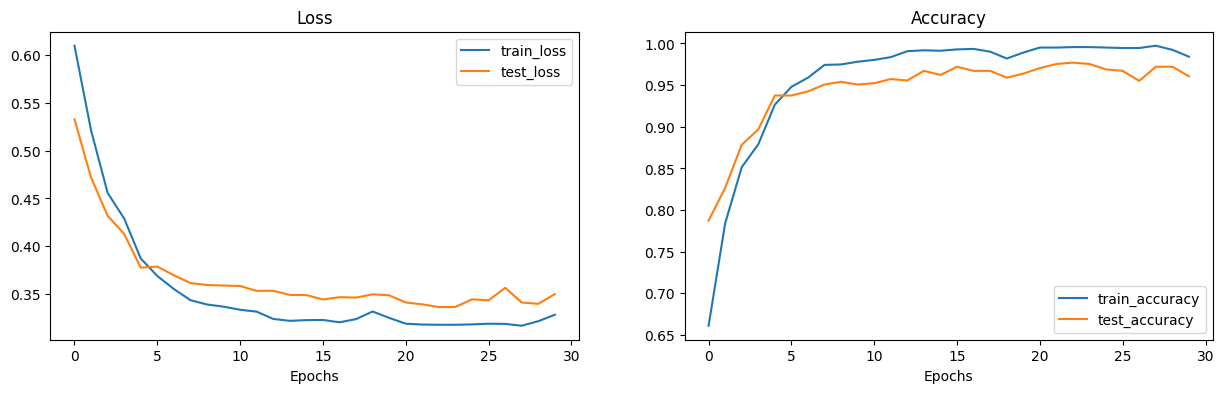

In [22]:
plot_loss_curves(model_results)

## Save model

In [23]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "BrainTumorModelPytorch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\BrainTumorModelPytorch.pth


## Val data

In [31]:
loaded_model = CNNModel(256).to('cuda')
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=57600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Model on device:
cuda:0


C:\Users\84945\AppData\Local\Temp\ipykernel_23016\2432122749.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [33]:
def make_predictions(model, dataloader, device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for batch in dataloader:
            X, _ = batch  # Assuming the dataloader returns a tuple (inputs, labels)
            X = X.to(device)
            pred_logit = model(X)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_probs.append(pred_prob.cpu())
    
    return torch.cat(pred_probs, dim=0)

In [34]:
loaded_pred_probs = make_predictions(loaded_model,
                                     val_dataloader,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

In [43]:
print(val_dataloader.dataset.targets)
print(len(val_dataloader.dataset.targets))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [37]:
print(loaded_pred_classes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [44]:
numpy_array = loaded_pred_classes.cpu().numpy()
print(numpy_array)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
tn, fp, fn, tp = confusion_matrix(val_dataloader.dataset.targets, numpy_array).ravel()
print('F1 score:', f1_score(val_dataloader.dataset.targets, numpy_array))



F1 score: 0.9619834710743802


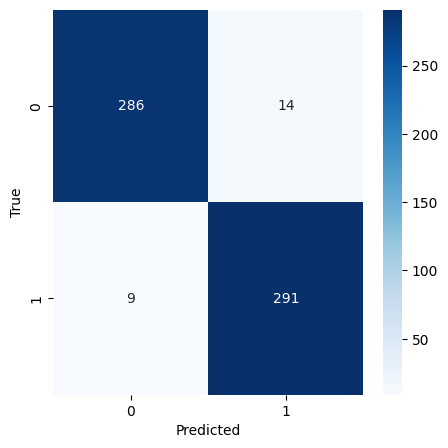

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(val_dataloader.dataset.targets, numpy_array), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()